# Using the yt-project to analysis ARK results

This short guid will show you how to load ARK simulation output files in the volumetric visualisation software, the [yt-project](https://yt-project.org). yt is "an open source, permissively licensed python package for analysis and visualising volumetric data".

Data, generated by codes that are officially supported by yt, are provide access via a frontend which is effectively hidden from the user. For non-supported codes, like ARK, there is a generic interface which allows users to pass numpy arrays to yt. This is the method that will be followed here.[^1]

Full documentation for the project can be found [here](https://yt-project.org/doc/) and gives a comprehensive overview and detailed instruction of the various aspects and uses for yt. As the yt documentation is so detailed we will not attempt to replace it with this short guide, instead we will go through the main steps involved in extracting data from hdf5 files using the python package h5py and setting up the necessary variables for loading the data into to yt.

First we start by loading yt and the modules we'll be using for checking the directory for .h5 files and reading then in.

[^1]: this may change and direct support added to yt for ARK outputs, if using yt with ARK data proves **very** useful.

In [1]:
import os
import numpy as np
import h5py
import yt
yt.funcs.mylog.setLevel(20)

The `.setLevel()` method specifies the amount of log information we want yt to print. The various values can be found under the [FAQ's](https://yt-project.org/doc/faq/index.html) section of the yt documentation.

Next we specify the folder that contains the output files and search for files with the .h5 extension. Then sort the files in ascending order. This last step is important as the result of the `listdir` and `endswith` methods from the `os` library, result in a list of files with arbitrary order.

In [2]:
folder = '/Users/sdaley/Work/Programs/ARK/build/output/'
file_list = [f for f in os.listdir(folder) if f.endswith('.h5')]
file_list.sort()

Load the hdf5 file is read only mode (`'r+'`) using the h5py library method `File`. We will load the data into the object `ek_data`, which will allow us to still access the original data if there is any analysis we can't do with yt directly.

In [3]:
ek_data = h5py.File(folder + file_list[0], 'r')

Once the data file is loaded it acts much like a python object. A [full reference guide](http://docs.h5py.org/en/stable/) is provided by the h5py project and details how to use python to interface with this file format.

First we'd like to know what data is contained in our file, we can check this by iterating over the keys and their associated values using a `for` loop. We can do the same for the attributes which describe the properties of the simulation. Both the data and the attributes tell us everything we need to phase the input to yt.

In [4]:
for name, value in zip(ek_data.keys(), ek_data.values()):
    print(name, ':', value)

Rstar_h : <HDF5 dataset "Rstar_h": shape (), type "<f8">
energy : <HDF5 dataset "energy": shape (40, 160), type "<f8">
extent : <HDF5 dataset "extent": shape (3,), type "<f8">
gamma : <HDF5 dataset "gamma": shape (), type "<f8">
mmw : <HDF5 dataset "mmw": shape (), type "<f8">
mx : <HDF5 dataset "mx": shape (40, 160), type "<f8">
my : <HDF5 dataset "my": shape (40, 160), type "<f8">
origin : <HDF5 dataset "origin": shape (3,), type "<f8">
rho : <HDF5 dataset "rho": shape (40, 160), type "<f8">
scalar : <HDF5 dataset "scalar": shape (40, 160), type "<f8">
spacing : <HDF5 dataset "spacing": shape (3,), type "<f8">


In [5]:
for name, value in zip(ek_data.attrs.keys(), ek_data.attrs.values()):
    print(name, '=', value)

total time = 0.0
nx = 160
ny = 40
nz = 1
iOutput = 0
iStep = 0
ghost zone included = 0
git branch = b'master'
git commit = b'c06c0a0-dirty'


The standard output variables of ARK are the conservative variables: density, energy and the momentum components. In order for yt to calculate derived fields such as e.g. pressure gradients, we need to supply it with with primitive variables. At the time of writing, we also need to give yt the temperature, as for some reason it is not derived along with the other derived fields (this may change in the future).

In [1]:
def kinetic_energy(ek_data):
    return 0.5*(ek_data['mx'][:, :]**2 \
               + ek_data['my'][:, :]**2) \
               *ek_data['rho'][:, :]

def pressure(ek_data):
    return (ek_data['gamma'][()] - 1.0) \
            *(ek_data['energy'][:, :] \
            - kinetic_energy(ek_data))

def temperature(ek_data):
    m_H = 1.67372e-27
    k_B = 1.38065e-23
    return m_H*ek_data['mmw'][()]*pressure(ek_data) \
           /(ek_data['rho'][:, :]*k_B)

def velocity_x(ek_data):
    return ek_data['mx'][:, :]/ek_data['rho'][:, :]

def velocity_y(f):
    return ek_data['my'][:, :]/ek_data['rho'][:, :]

Next, we build a dictionary of the simulation data fields where the key is a yt recognised field and the value is the corresponding ARK data array. As yt makes no distinction between 2D and 3D data, its API is written to accept 3D data by default. This means, if our data in the ARK output is 2D, we need to append the z axis to the data arrays that we intend to load into yt. 

We also need to define the bounding box (`bbox`) which describes the extent of the simulation domain. This is done by accessing the meta data contained in the ARK .h5 file; `origin` and `extent`.

In [8]:
if ek_data.attrs['nz'] < 2:
    data_shape = (1, ek_data.attrs['ny'], ek_data.attrs['nx'])

    data = dict(density = (ek_data['rho'][:, :].reshape(data_shape), 
                           "code_mass/code_length**3"),
                pressure = (pressure(ek_data).reshape(data_shape), 
                            "code_mass/(code_length*code_time**2)"),
                temperature = (temperature(ek_data).reshape(data_shape), 
                               "code_temperature"),
                velocity_x = (velocity_x(ek_data).reshape(data_shape), 
                              "code_length/code_time"),
                velocity_y = (velocity_y(ek_data).reshape(data_shape), 
                              "code_length/code_time"))
else:
    data = dict(density = (ek_data['rho'][:, :], 
                           "code_mass/code_length**3"),
                pressure = (pressure(ek_data), 
                            "code_mass/(code_length*code_time**2)"),
                temperature = (temperature(ek_data), 
                               "code_temperature"),
                velocity_x = (velocity_x(ek_data), 
                              "code_length/code_time"),
                velocity_y = (velocity_y(ek_data), 
                              "code_length/code_time"))

bbox = np.array([[ek_data['origin'][0], ek_data['extent'][0]], 
                 [ek_data['origin'][1], ek_data['extent'][1]], 
                 [ek_data['origin'][2], ek_data['extent'][2]]])

Finally, we load the `data` dict into yt, specify the data array size as `data['density'][0].shape` (the choice of field ad 'density' is arbitrary), pass the bounding box via `bbox`, state the simulation time `f.attrs['total time']` and the geometry together with the dimension ordering. 

In [10]:
ds = yt.load_uniform_grid(data, 
                          data['density'][0].shape, 
                          bbox=bbox,
                          sim_time=ek_data.attrs['total time'],
                          geometry=("cartesian", ("z", "y", "x")))

yt : [INFO     ] 2018-11-12 15:54:23,574 Parameters: current_time              = 0.0
yt : [INFO     ] 2018-11-12 15:54:23,576 Parameters: domain_dimensions         = [  1  40 160]
yt : [INFO     ] 2018-11-12 15:54:23,577 Parameters: domain_left_edge          = [0. 2. 0.]
yt : [INFO     ] 2018-11-12 15:54:23,578 Parameters: domain_right_edge         = [1. 3. 4.]
yt : [INFO     ] 2018-11-12 15:54:23,579 Parameters: cosmological_simulation   = 0.0


Our data from the ARK simulation file is now loaded into yt. We can check what fields have been recognised by running the following loop over `ds.field_list`: 

In [11]:
for i in sorted(ds.field_list):
    print(i)

('stream', 'density')
('stream', 'pressure')
('stream', 'temperature')
('stream', 'velocity_x')
('stream', 'velocity_y')


/Users/sdaley/Work/Programs/miniconda3/lib/python3.6/site-packages/yt/units/yt_array.py:978: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  ret = super(YTArray, self).__getitem__(item)
/Users/sdaley/Work/Programs/miniconda3/lib/python3.6/site-packages/yt/fields/fluid_fields.py:201: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  new_field[slice_3d] = f


However, in addition to the original field given to yt in the `data` `dict`, yt has automatically derived several fields with we can use to either plot or analysis the data set with. These additional derived fields are not pre-calculated and stored in memory as this would be criminally memory inefficient, therefore these fields are simply call backs which ally the correct calculation when the field is invoked. We can list these derived fields by looping over the `ds.derived_field_list`:

In [12]:
for i in sorted(ds.derived_field_list):
    print(i)

('gas', 'H_nuclei_density')
('gas', 'He_nuclei_density')
('gas', 'averaged_density')
('gas', 'baroclinic_vorticity_magnitude')
('gas', 'baroclinic_vorticity_x')
('gas', 'baroclinic_vorticity_y')
('gas', 'baroclinic_vorticity_z')
('gas', 'cell_mass')
('gas', 'cell_volume')
('gas', 'density')
('gas', 'density_gradient_magnitude')
('gas', 'density_gradient_x')
('gas', 'density_gradient_y')
('gas', 'density_gradient_z')
('gas', 'dx')
('gas', 'dy')
('gas', 'dynamical_time')
('gas', 'dz')
('gas', 'emission_measure')
('gas', 'entropy')
('gas', 'kT')
('gas', 'mazzotta_weighting')
('gas', 'path_element_x')
('gas', 'path_element_y')
('gas', 'path_element_z')
('gas', 'pressure')
('gas', 'pressure_gradient_magnitude')
('gas', 'pressure_gradient_x')
('gas', 'pressure_gradient_y')
('gas', 'pressure_gradient_z')
('gas', 'sound_speed')
('gas', 'szy')
('gas', 'temperature')
('gas', 'velocity_x')
('gas', 'velocity_y')
('gas', 'vertex_x')
('gas', 'vertex_y')
('gas', 'vertex_z')
('gas', 'x')
('gas', 'xray

Now that we have our data in yt and checked which fields are available to us, we can experiment with its analysis methods. For example, if we want to know the total entropy in the simulation all we have to do is invoke the following lines of code:

In [13]:
ad = ds.all_data()
print(ad.quantities.total_quantity(('gas', 'entropy')))

2.290814303714904e-19 cm**2*keV


The units of the output are spurious however as we have set the units of our input data to code units. This is a current limitation of using the `yt.load_generic_grid()` method.

We can also use yt to plot the quantities in out data set. below the code necessary for producing a slice plot of the density.

yt : [INFO     ] 2018-11-12 15:54:27,420 xlim = 0.000000 4.000000
yt : [INFO     ] 2018-11-12 15:54:27,421 ylim = 2.000000 3.000000
yt : [INFO     ] 2018-11-12 15:54:27,422 xlim = 0.000000 4.000000
yt : [INFO     ] 2018-11-12 15:54:27,422 ylim = 2.000000 3.000000
yt : [INFO     ] 2018-11-12 15:54:27,430 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800



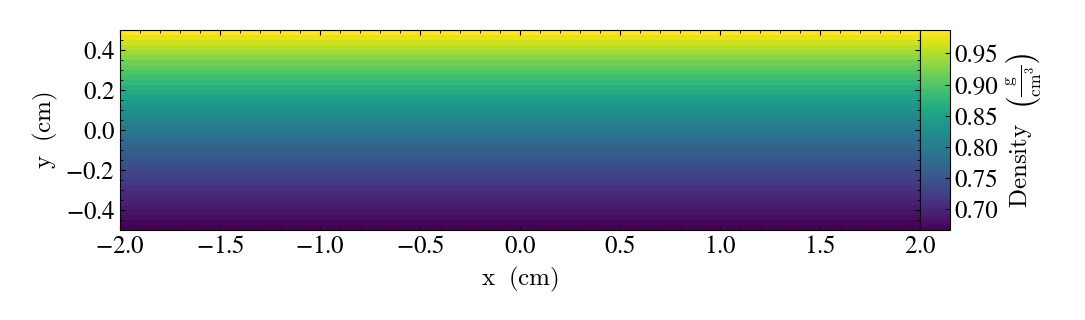

In [14]:
field = ('gas', 'density')
slc = yt.SlicePlot(ds, "z", field)#, origin=(0.0, 2.0, 'window'))
slc.set_cmap(field, 'viridis')
slc.set_log(field, False)
slc.show()

In [15]:
grad_fields = ds.add_gradient_fields(("gas","temperature"))

/Users/sdaley/Work/Programs/miniconda3/lib/python3.6/site-packages/yt/units/yt_array.py:978: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  ret = super(YTArray, self).__getitem__(item)
/Users/sdaley/Work/Programs/miniconda3/lib/python3.6/site-packages/yt/fields/fluid_fields.py:201: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  new_field[slice_3d] = f



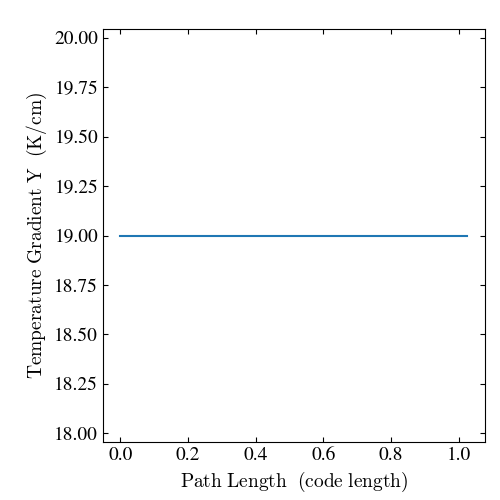

In [16]:
plot = yt.LinePlot(ds, 'temperature', [0.0, 2.0, 3.0], [0.0, 2.0, 2.0], 40)
plot.set_log('temperature', False)
plot.show()